In [40]:
%matplotlib inline
import pylab as pl
import numpy as np

In [41]:
from astropy import units as u

In [42]:
from astropy.table import Table

In [43]:
import imf

In [44]:
import glob

In [45]:
from sedfitter.sed import SEDCube

In [46]:
version = 'r+23_models-1.1'

In [47]:
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/parameters.fits')

In [48]:
path=f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/convolved/JWST/'

In [49]:
geoms = [x.split("/")[-2] for x in glob.glob(f'/blue/adamginsburg/richardson.t/research/flux/{version}/*/')
         if x.split("/")[-2].startswith('s')]

In [50]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/{geom}/parameters.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [51]:
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [52]:
flux_b7 = 98*u.mJy
flux_b3 = 1.77*u.mJy
ulim_24um = (1.25*u.Jy).to(u.mJy)
ulim_70um = (73.9*u.Jy).to(u.mJy)

In [53]:
matchtable = {}
for geometry in geoms:

    print(geometry)
    pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
    if 'disk.mass' in pars.colnames:
        seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
        pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
        pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
        pars['f24um'] = seds.val[:,7,81]
        pars['f70um'] = seds.val[:,7,64]

        sel = (
               (((pars['f0.8mm'] / 8.0**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.0**2 < flux_b7*1.25))
                | ((pars['f3mm'] / 8.0**2 > flux_b3*0.75) & (pars['f3mm'] / 8.0**2 < flux_b3*1.25)))
               & (pars['f24um'] / 8.0**2 < ulim_24um)
               & (pars['f70um'] / 8.0**2 < ulim_70um)
               & np.isfinite(pars['f3mm'])
               & np.isfinite(pars['f0.8mm'])
        )
        #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
        print(geometry, sel.sum())

        if sel.sum() > 0:
            matchtable[geometry] = pars[sel]
matchtable.keys()

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 0
spubsmi
spubsmi 0
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 1
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 0
spubhmi
spubhmi 75
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 0


dict_keys(['spu-smi', 'spubhmi'])

In [54]:
from astropy import table
matched = table.vstack(list(matchtable.values()))

In [55]:
matched.colnames

['MODEL_NAME',
 'star.radius',
 'star.temperature',
 'disk.mass',
 'disk.rmax',
 'disk.beta',
 'disk.p',
 'disk.h100',
 'envelope.rho_0',
 'envelope.rc',
 'ambient.density',
 'ambient.temperature',
 'scattering',
 'inclination',
 'Model Luminosity',
 'Line-of-Sight Masses',
 'Sphere Masses',
 'Outer Radius',
 'Line-of-Sight Weighted Temperatures',
 'Sphere Weighted Temperatures',
 'Disk Minimum Q',
 'f0.8mm',
 'f3mm',
 'f24um',
 'f70um',
 'cavity.power',
 'cavity.theta_0',
 'cavity.rho_0',
 'disk.rmin',
 'envelope.rmin']

In [56]:
matched[matched['Sphere Masses'][:,7] < 5]

MODEL_NAME,star.radius,star.temperature,disk.mass,disk.rmax,disk.beta,disk.p,disk.h100,envelope.rho_0,envelope.rc,ambient.density,ambient.temperature,scattering,inclination,Model Luminosity,Line-of-Sight Masses,Sphere Masses,Outer Radius,Line-of-Sight Weighted Temperatures,Sphere Weighted Temperatures,Disk Minimum Q,f0.8mm,f3mm,f24um,f70um,cavity.power,cavity.theta_0,cavity.rho_0,disk.rmin,envelope.rmin
,,,,,,,,,,,,,,solLum,,,,,,,mJy,mJy,mJy,mJy,,,,,
bytes20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64[20],float64[20],float64,float64[20],float64[20],float64,float32,float32,float32,float32,float64,float64,float64,float64,float64
d7jKGubi_08,12.18,19460.0,4.278e-06,1039.0,1.187,-0.549,15.86,9.637e-19,1039.0,1e-23,10.0,1,79.92905934101623,19167.240783322904,0.0 .. 73238.55441150526,0.0 .. 33315.157159809336,1750233.1811750764,-- .. 10.670229671262074,-- .. 11.568554083276256,--,6141.025,58.653385,76603.77,3789865.8,1.639,29.71,3.066e-22,979.6,979.6
d7jKGubi_09,12.18,19460.0,4.278e-06,1039.0,1.187,-0.549,15.86,9.637e-19,1039.0,1e-23,10.0,1,81.57387824150712,19167.240783322904,0.0 .. 73238.55441150561,0.0 .. 33315.157159809336,1750233.1811750764,-- .. 10.670229671262017,-- .. 11.568554083276256,--,6072.5225,57.5914,76316.53,3791714.2,1.639,29.71,3.066e-22,979.6,979.6
fdmU15mX_01,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,2.4961118893949283,22189.97536210316,1.867307616206713e-06 .. 428632.1769416563,0.0 .. 80311.14701590512,3171125.4961604667,83.56546696992744 .. 10.192502313276826,-- .. 11.079789759694272,--,12796.6455,122.589966,2390.0757,4318282.5,1.971,5.561,3.59e-23,789.8,789.8
fdmU15mX_02,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,15.926160000355093,22189.97536210316,0.0008511532923543365 .. 428632.1769416494,0.0 .. 80311.14701590512,3171125.4961604667,51.33810325304872 .. 10.192502313278098,-- .. 11.079789759694272,--,13077.6,126.16125,980.6749,4217457.5,1.971,5.561,3.59e-23,789.8,789.8
fdmU15mX_03,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,27.404614064037677,22189.97536210316,0.0007931249368588204 .. 428632.17694154545,0.0 .. 80311.14701590512,3171125.4961604667,56.778929238989555 .. 10.192502313277549,-- .. 11.079789759694272,--,12924.408,123.64007,890.65546,4194349.0,1.971,5.561,3.59e-23,789.8,789.8
fdmU15mX_04,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,34.08393894059998,22189.97536210316,0.001297053090229544 .. 428632.1769415289,0.0 .. 80311.14701590512,3171125.4961604667,50.298266604687804 .. 10.192502313276412,-- .. 11.079789759694272,--,12961.733,124.04886,853.5763,4188899.8,1.971,5.561,3.59e-23,789.8,789.8
fdmU15mX_05,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,45.18643700081272,22189.97536210316,0.0012530011070205989 .. 428632.1769414928,0.0 .. 80311.14701590512,3171125.4961604667,51.47053072179881 .. 10.192502313275883,-- .. 11.079789759694272,--,12946.762,123.890434,800.4009,4172606.5,1.971,5.561,3.59e-23,789.8,789.8
fdmU15mX_06,6.254,28170.0,0.002919,495.5,1.201,-0.2486,1.618,7.033e-18,495.5,1e-23,10.0,1,50.78406106432863,22189.97536210316,0.0008412579034193889 .. 428632.17694148363,0.0 .. 80311.14701590512,3171125.4961604667,54.244909197632225 .. 10.192502313276107,-- .. 11.079789759694272,--,13182.469,126.971794,775.6913,4170394.0,1.971,5.561,3.59e-23,789.8,789.8


(array([50.,  0.,  0.,  0.,  8.,  0.,  3.,  4.,  0., 11.]),
 array([ 0.        ,  1.57988256,  3.15976511,  4.73964767,  6.31953023,
         7.89941279,  9.47929534, 11.0591779 , 12.63906046, 14.21894301,
        15.79882557]),
 <BarContainer object of 10 artists>)

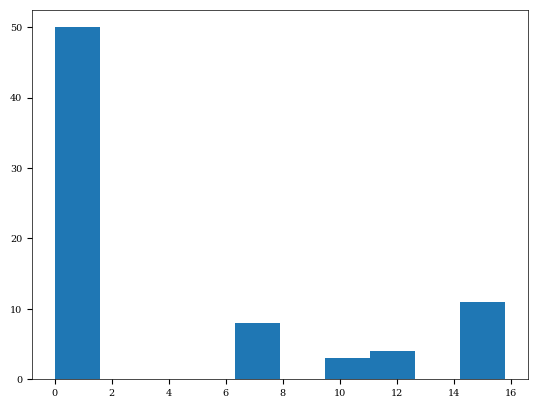

In [57]:
pl.hist(matched['Sphere Masses'][:,7])

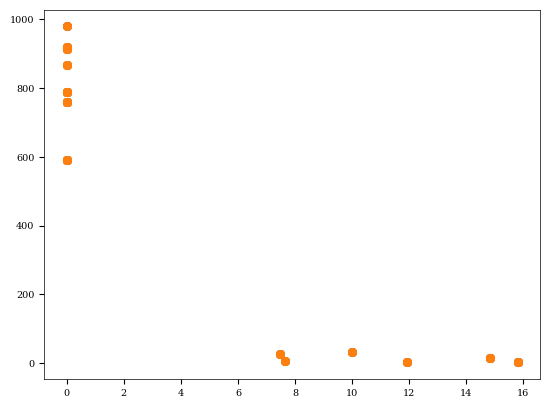

In [58]:

pl.scatter(matched['Sphere Masses'][:,7],
           matched['disk.rmin'])
pl.scatter(matched['Sphere Masses'][:,7],
           matched['envelope.rmin'])


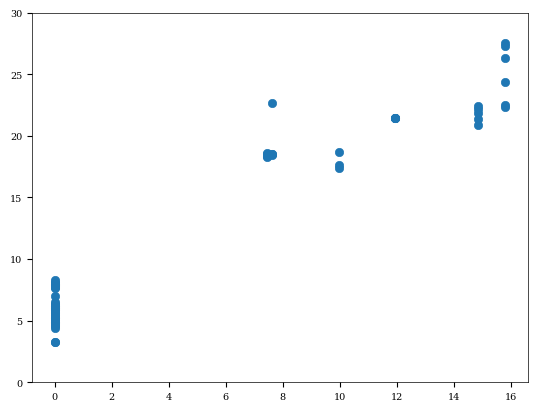

In [59]:
pl.scatter(matched['Sphere Masses'][:,7],
           matched['Line-of-Sight Masses'][:,7])
pl.ylim(0,30);

In [60]:
import numpy as np

(array([ 4.,  0.,  0.,  0.,  5., 20., 22., 21.,  3.,  1.]),
 array([3.4141264 , 3.54690737, 3.67968834, 3.81246931, 3.94525027,
        4.07803124, 4.21081221, 4.34359318, 4.47637414, 4.60915511,
        4.74193608]),
 <BarContainer object of 10 artists>)

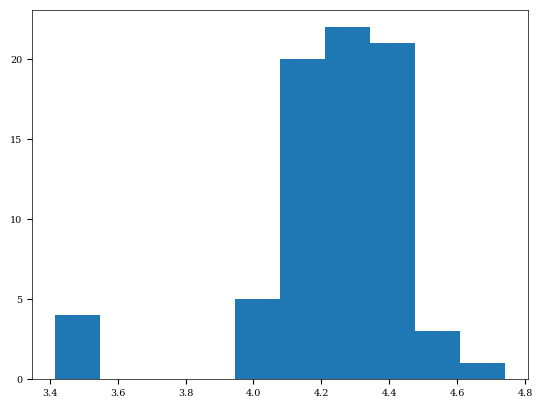

In [61]:
pl.hist(np.log10(matched['Model Luminosity']))

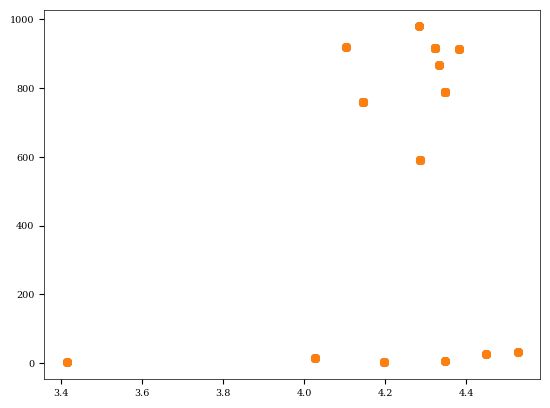

In [62]:
pl.scatter(np.log10(matched['Model Luminosity']),
           matched['disk.rmin'])
pl.scatter(np.log10(matched['Model Luminosity']),
           matched['envelope.rmin'])

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 19.]),
 array([ 11.86781369,  25.57942596,  39.29103823,  53.0026505 ,
         66.71426277,  80.42587504,  94.13748731, 107.84909957,
        121.56071184, 135.27232411, 148.98393638]),
 <BarContainer object of 10 artists>)

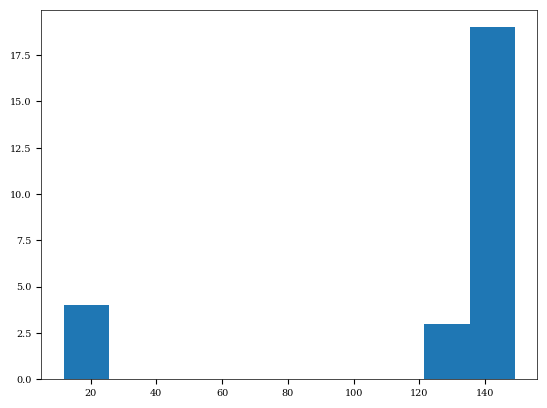

In [63]:
pl.hist(matched['Sphere Weighted Temperatures'][:,7])

(array([50.,  0.,  0.,  2., 12.,  8.,  0.,  0.,  0.,  4.]),
 array([ 26.38871725,  40.85183458,  55.31495191,  69.77806924,
         84.24118657,  98.7043039 , 113.16742123, 127.63053856,
        142.09365589, 156.55677322, 171.01989055]),
 <BarContainer object of 10 artists>)

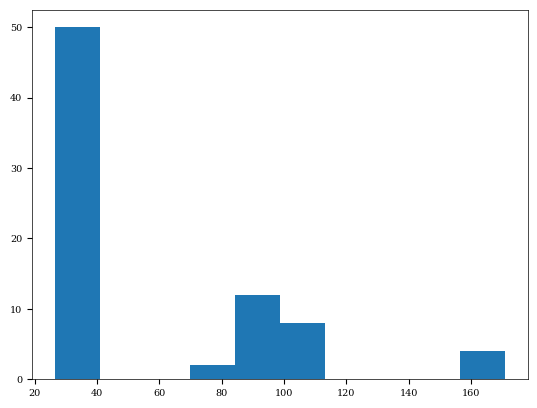

In [64]:
pl.hist(matched['Line-of-Sight Weighted Temperatures'][:,7])

(array([18., 30.,  2.,  0.,  0.,  2.,  8., 12.,  1.,  3.]),
 array([ 3.27714142,  5.70538056,  8.13361969, 10.56185882, 12.99009795,
        15.41833708, 17.84657621, 20.27481534, 22.70305447, 25.1312936 ,
        27.55953273]),
 <BarContainer object of 10 artists>)

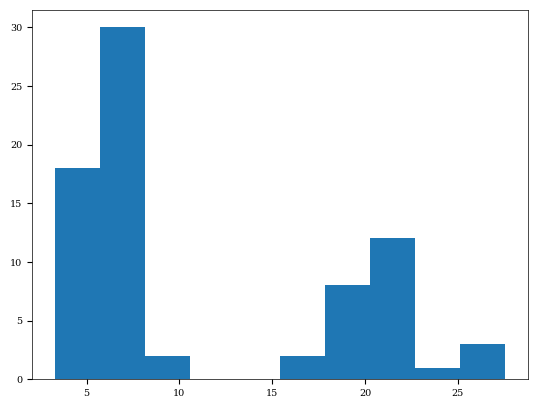

In [65]:
pl.hist(matched['Line-of-Sight Masses'][:,7])

(array([18., 30.,  2.,  0.,  0.,  2.,  8., 12.,  1.,  3.]),
 array([9.54103379e+22, 1.66105827e+23, 2.36801316e+23, 3.07496805e+23,
        3.78192294e+23, 4.48887783e+23, 5.19583272e+23, 5.90278762e+23,
        6.60974251e+23, 7.31669740e+23, 8.02365229e+23]),
 <BarContainer object of 10 artists>)

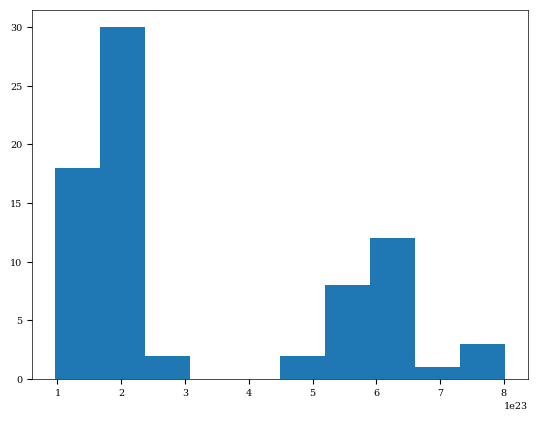

In [66]:
pl.hist((matched['Line-of-Sight Masses'][:,7]*u.M_sun/(2.34*u.Da) / (np.pi*(5000*u.au)**2)).to(u.cm**-2))

In [67]:
print("TEST")

TEST


In [68]:
from astropy.visualization import quantity_support

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 181
spubsmi
spubsmi 139
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 81
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 26
spubhmi
spubhmi 598
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 6


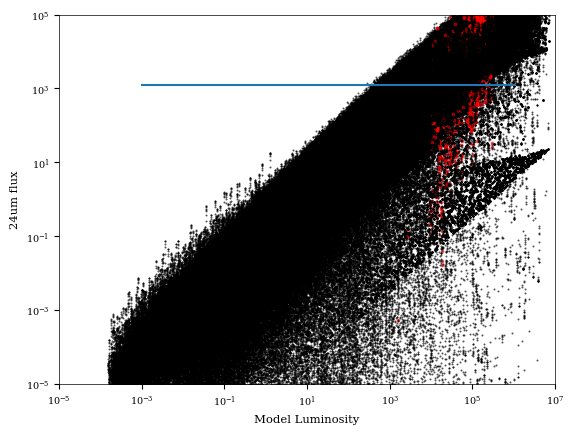

In [79]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (pars['f0.8mm'] / 8.0**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.0**2 < flux_b7*1.25)
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['Model Luminosity'], pars['f24um']/8.0**2, s=1, alpha=0.5, color='k')
            axlims = pl.gca().axis()
            pl.scatter(pars['Model Luminosity'][sel], pars['f24um'][sel]/8.0**2, s=5, alpha=0.5, label=geometry, color='r')

    #pl.gca().axis(axlims)
    pl.loglog()
    pl.plot([1e-3, 1e6]*u.L_sun, u.Quantity([ulim_24um, ulim_24um]))
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("Model Luminosity")
pl.axis([1e-5, 1e7, 1e-5, 1e5]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 181
spubsmi
spubsmi 139
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 81
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 26
spubhmi
spubhmi 598
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 6


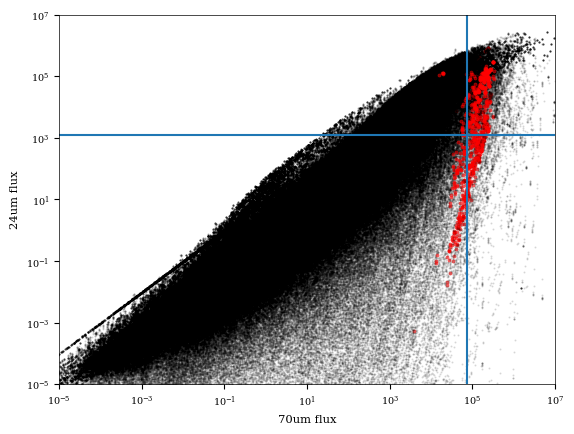

In [80]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (pars['f0.8mm'] / 8.0**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.0**2 < flux_b7*1.25)
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['f70um']/8.0**2, pars['f24um']/8.0**2, s=1, alpha=0.1, color='k')
            pl.scatter(pars['f70um'][sel]/8.0**2, pars['f24um'][sel]/8.0**2, s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    pl.axhline(ulim_24um)
    pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("70um flux");
pl.axis([1e-5, 1e7, 1e-5, 1e7]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 202
spubsmi
spubsmi 150
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 86
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 26
spubhmi
spubhmi 836
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 23


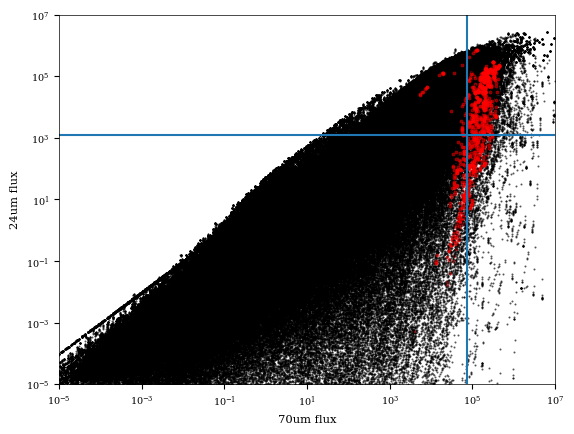

In [81]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (((pars['f0.8mm'] / 8.0**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.0**2 < flux_b7*1.25))
                   | ((pars['f3mm'] / 8.0**2 > flux_b3*0.75) & (pars['f3mm'] / 8.0**2 < flux_b3*1.25)))
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['f70um']/8.0**2, pars['f24um']/8.0**2, s=1, alpha=0.5, color='k')
            pl.scatter(pars['f70um'][sel]/8.0**2, pars['f24um'][sel]/8.0**2, s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    pl.axhline(ulim_24um)
    pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("24um flux");
    pl.xlabel("70um flux");
pl.axis([1e-5, 1e7, 1e-5, 1e7]);

s---s-i
s-pbsmi
s-p-hmi
spu-hmi
spu-hmi 39
spubsmi
spubsmi 15
s-pbhmi
s-u-smi
s-ubhmi
spu-smi
spu-smi 41
s-u-hmi
s-ubsmi
sp--hmi
sp--hmi 0
sp--s-i
sp--s-i 0
spubhmi
spubhmi 120
s---smi
sp--smi
sp--smi 0
s-p-smi
sp--h-i
sp--h-i 0


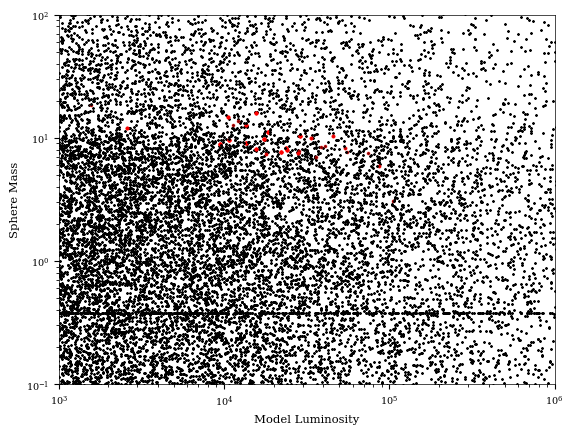

In [82]:
with quantity_support():
    for geometry in geoms:
    
        print(geometry)
        pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geometry}_augmented.fits')
        if 'disk.mass' in pars.colnames:
            seds = SEDCube.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geometry}/flux.fits')
            pars['f0.8mm'] = seds.val[:,7,27] # 27, 7 = 820 micron, 7000 AU
            pars['f3mm'] = seds.val[:,7,7] # 7, 7 = 3000 micron, 7000 AU
            pars['f24um'] = seds.val[:,7,81]
            pars['f70um'] = seds.val[:,7,64]
    
            sel = (((pars['f0.8mm'] / 8.0**2 > flux_b7*0.75) & (pars['f0.8mm'] / 8.0**2 < flux_b7*1.25))
                   | ((pars['f3mm'] / 8.0**2 > flux_b3*0.75) & (pars['f3mm'] / 8.0**2 < flux_b3*1.25)))
            sel &= pars['f70um'] / 8.0 ** 2 < ulim_70um
            sel &= pars['f24um'] / 8.0 ** 2 < ulim_24um
            #sel &= seds.val[:,3,20] > 2.5*u.mJy * (8/1)**2
            print(geometry, sel.sum())
            pl.scatter(pars['Model Luminosity'], pars['Sphere Masses'][:,7], s=1, alpha=0.5, color='k')
            pl.scatter(pars['Model Luminosity'][sel], pars['Sphere Masses'][:,7][sel], s=5, alpha=0.5, label=geometry, color='r')
    
    pl.loglog()
    #pl.axhline(ulim_24um)
    #pl.axvline(ulim_70um)
    #pl.legend(loc='best')
    pl.ylabel("Sphere Mass");
    pl.xlabel("Model Luminosity");
pl.axis([1e-4, 1e7, 5e-4, 2e3]);
pl.axis([1e3, 1e6, 0.1, 1e2]);

In [83]:
seds.apertures[7]
seds.wav[27]

<Quantity 822.92758008 um>

In [84]:
seds.wav[81]

<Quantity 23.80343957 um>

In [85]:
seds.wav[64]

<Quantity 72.61931817 um>

In [86]:
seds.apertures[7]
seds.wav[7]

<Quantity 3056.74083122 um>

In [87]:
seds.wav.shape

(200,)

In [88]:
seds.val.shape

(90000, 20, 200)